# About this notebook
- PyTorch nfnet_l0 starter code
- StratifiedKFold 4 folds
- training notebook is [here](https://www.kaggle.com/yasufuminakama/seti-nfnet-l0-starter-training)

If this notebook is helpful, feel free to upvote :)

# CFG

In [1]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
    model_name='tf_efficientnet_b3_ns'
    size=512
    batch_size=32
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0,1,2,3,4]
    tta = 5
    multisample_dropout=False

# Library

In [2]:
# ====================================================
# Library
# ====================================================

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [3]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file='inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Loading

In [4]:
test = pd.read_csv('seti-breakthrough-listen/sample_submission.csv')

def get_test_file_path(image_id):
    return "seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

test['file_path'] = test['id'].apply(get_test_file_path)

display(test.head())

,id,target,file_path
0,000bf832cae9ff1,0.5,seti-breakthrough-listen/test/0/000bf832cae9ff...
1,000c74cc71a1140,0.5,seti-breakthrough-listen/test/0/000c74cc71a114...
2,000f5f9851161d3,0.5,seti-breakthrough-listen/test/0/000f5f9851161d...
3,000f7499e95aba6,0.5,seti-breakthrough-listen/test/0/000f7499e95aba...
4,00133ce6ec257f9,0.5,seti-breakthrough-listen/test/0/00133ce6ec257f...


# Dataset

In [5]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.load(file_path)
        image = image[::2]
        image = image.astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        return image

# Transforms

In [6]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            ToTensorV2(),
        ])

def get_test_transforms(mode):
    if mode == 0:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, p=0.25),
            A.OneOf([
                A.MotionBlur(p=1.0),
                A.GaussianBlur(p=1.0),
                A.GaussNoise(p=1.0),
            ], p=0.2),
            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0, p=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.0, p=1.0),
                A.ElasticTransform(alpha=3, p=1.0),
            ], p=0.2),
            A.IAASharpen(p=0.25),
            A.Cutout(p=0.3),
            ToTensorV2(),
        ])
    elif mode == 1:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.ShiftScaleRotate(rotate_limit=0, p=0.25),
            #A.OpticalDistortion(distort_limit=1.0, p=0.4),
            #A.GaussianBlur(p=0.4),
            #A.IAASharpen(p=0.25),
            #A.Cutout(max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=1, p=0.3),
            ToTensorV2(),
        ])
    elif mode == 2:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, p=1.0),
            #A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, p=0.25),
            A.OpticalDistortion(distort_limit=1.0, p=0.2),
            #A.MotionBlur(p=0.2),
            A.IAASharpen(p=0.25),
            #A.Cutout(max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=1, p=0.3),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, p=1.0),
            ToTensorV2(),
        ])

In [7]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

# MODEL

In [8]:
class GAP(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1,1)).squeeze()

In [9]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        if  "eff" in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            #self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)
        elif "mixer" in self.cfg.model_name:
            self.n_features = self.model.head.in_features
            #self.model.head = nn.Linear(self.n_features, self.cfg.target_size)
        elif "resnest" in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            #self.model.fc = nn.Linear(self.n_features, self.cfg.target_size)
        elif "nfnet" in self.cfg.model_name:
            self.n_features = self.model.head.fc.in_features
            #self.model.head.fc = nn.Linear(self.n_features, self.cfg.target_size)
        self.dropout = nn.Dropout(0.2)
        self.global_pool = GAP()
        self.flatten = nn.Flatten()
        self.l0 = nn.Linear(self.n_features, self.cfg.target_size)
        
    def forward(self, x):
        features = self.model.forward_features(x)
        x = self.global_pool(features)
        x = self.flatten(x)
        if self.cfg.multisample_dropout:
            x = torch.mean(
                torch.stack(
                    [self.l0(self.dropout(x)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        else:
            x = self.l0(x)
        return x

# Helper functions

In [10]:
# ====================================================
# Helper functions
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# inference

In [11]:
# ====================================================
# inference
# ====================================================
model = CustomModel(CFG, pretrained=False)
model = replace_activations(model, torch.nn.ReLU, Mish())
MODEL_DIR = 'eff_b3_ns/'
predictions = []
states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth') for fold in CFG.trn_fold]
if CFG.tta == 4:
    for mode in range(CFG.tta):
        test_dataset = TestDataset(test, transform=get_test_transforms(mode))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions.append(inference(model, states, test_loader, device))
else:
        test_dataset = TestDataset(test, transform=get_test_transforms(5))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)

  0%|          | 0/1250 [00:00<?, ?it/s]

In [12]:
# submission
if CFG.tta == 4:
    test['target'] = np.mean(predictions, axis=0)
else:
    test['target'] = predictions
test[['id', 'target']].to_csv('submission.csv', index=False)
test[['id', 'target']].head()

,id,target
0,000bf832cae9ff1,0.055040
1,000c74cc71a1140,0.060592
2,000f5f9851161d3,0.056416
3,000f7499e95aba6,0.097937
4,00133ce6ec257f9,0.058025


<AxesSubplot:>

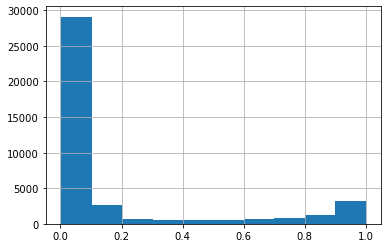

In [13]:
test['target'].hist()